In [1]:
import torch
import torch.nn as nn # for neural network stuff (stateful)
import torch.nn.functional as func # for neural network operations (stateless)
import numpy as np
import matplotlib.pyplot as plt

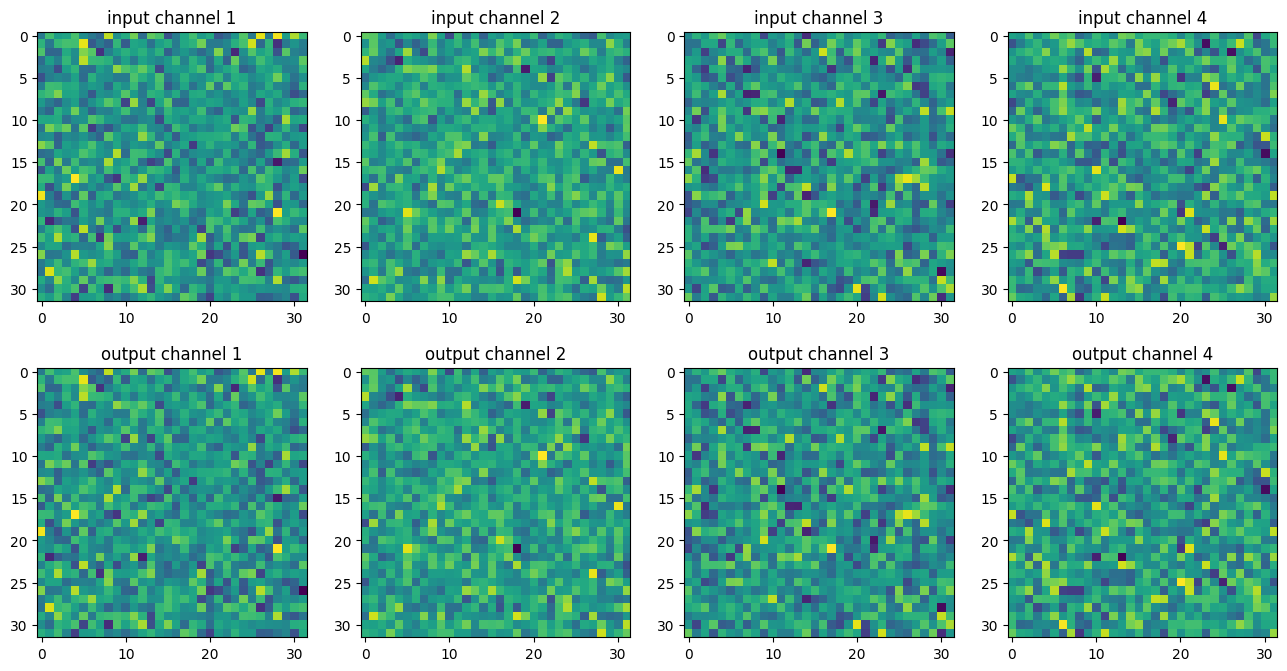

input shape: torch.Size([2, 64, 32, 32])
output shape: torch.Size([2, 128, 32, 32])
Total parameters in DCT module: 3216


In [41]:
#######
# DCT hyper parameters: reduction ratio, replication ratio, 

class DCT(nn.Module):
    def __init__(self, input_channels, reduc=4, repl=2):
        super(DCT, self).__init__()
        self.reduc = reduc
        self.repl = repl
        self.output_channels = input_channels * repl

        self.GAP = torch.nn.AdaptiveAvgPool2d(1)
        hidden_channels = input_channels // reduc
        self.fc1 = torch.nn.Conv2d(input_channels, hidden_channels, 1)
        self.fc2 = torch.nn.Conv2d(hidden_channels, self.output_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()
        
        replicated = x.repeat(1, self.repl, 1, 1) # dupliates channels of input tensor
        
        pool = self.GAP(x) # do the global average pooling
        
        first_FC = self.fc1(pool) 
        second_FC = self.fc2(first_FC)
        activation = self.sigmoid(second_FC)
        recalibrated = activation.view(b, self.output_channels, 1, 1)
        
        output = replicated + recalibrated
        
        return output

if __name__ == "__main__":
    # visualization plot
    fig, axarr = plt.subplots(2, 4, figsize=(16, 8))
    
    # test input
    test_input = torch.randn(2, 64, 32, 32)  

    # plot input
    for i in range(4):
        axarr[0, i].imshow(test_input[0, i].numpy(), cmap='viridis')
        axarr[0, i].set_title(f'input channel {i+1}')
    
    dct = DCT(input_channels=64, repl=2, reduc=4)
    output = dct(test_input)

    # plot output
    for i in range(4):
        axarr[1, i].imshow(output[0, i].detach().numpy(), cmap='viridis')
        axarr[1, i].set_title(f'output channel {i+1}')
    
    plt.show()
    print(f"input shape: {test_input.shape}")
    print(f"output shape: {output.shape}")
    
    # count parameters
    total = 0
    for parameter in dct.parameters():
        total = total + parameter.numel()
    print(f"Total parameters in DCT module: {total}")